# Visualizing CNN kernels and activations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Let's start by defining the model to finetune
# For this example we will use Alexnet
import torchvision.models as models

alexnet = models.alexnet(pretrained=True).to(device)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

torch.Size([64, 3, 11, 11])
torch.Size([192, 64, 5, 5])
torch.Size([384, 192, 3, 3])
torch.Size([256, 384, 3, 3])
torch.Size([256, 256, 3, 3])


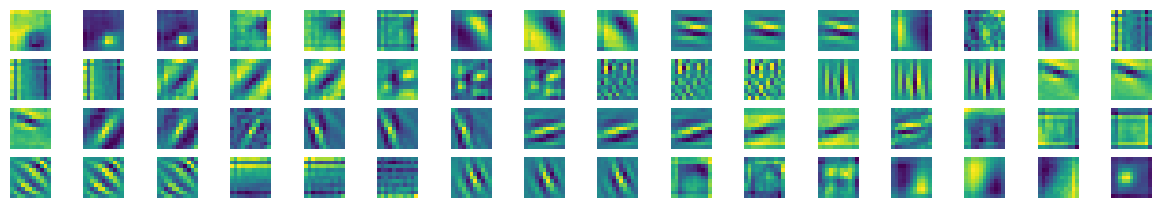

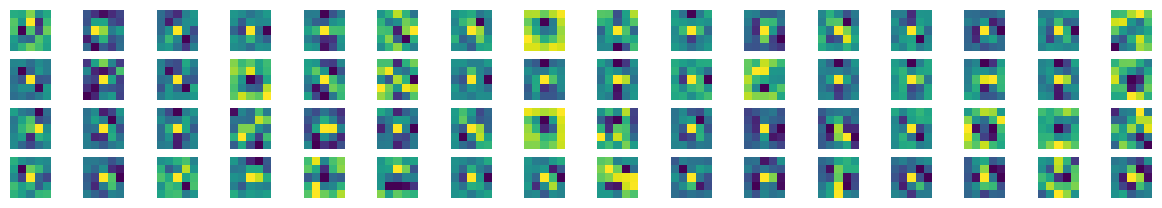

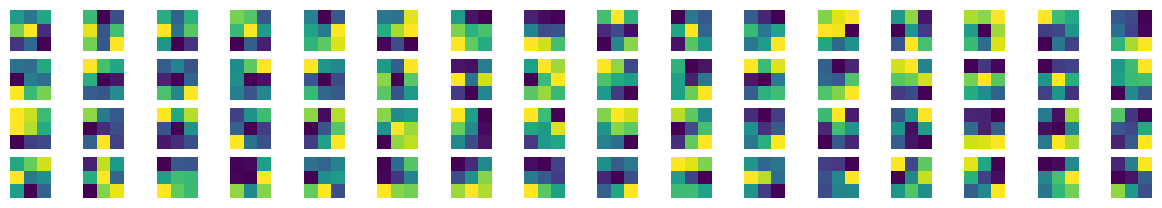

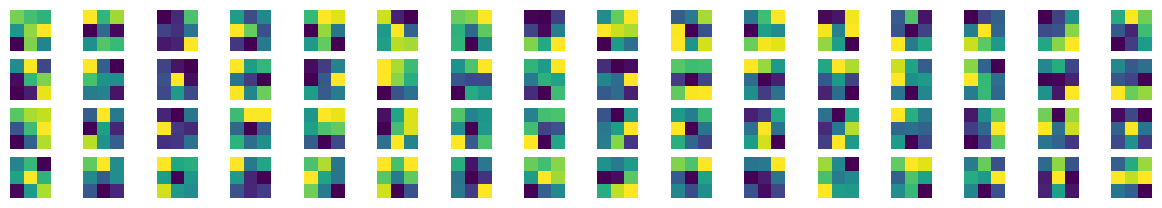

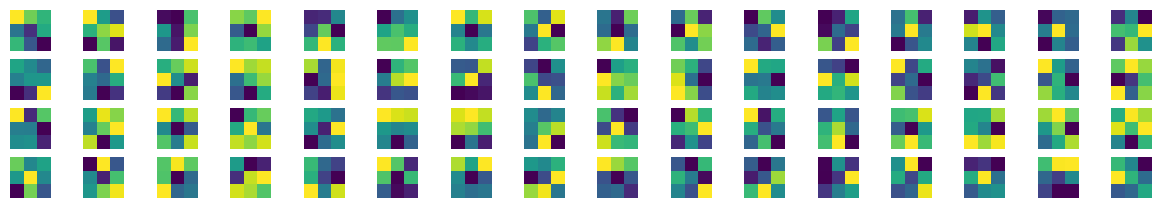

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

layers_list = [0,3,6,8,10] #kernels that we want to visualize

for k in layers_list:
    # get the kernels from the first layer
    # as per the name of the layer
    kernels = alexnet.features[k].weight.detach().clone().cpu()
    
    #check size for sanity check
    print(kernels.size())
    
    n,c,w,h = kernels.shape
    row_num = 8

    kernels = kernels.view(n*c, -1, w, h)

    rows = np.min((kernels.shape[0] // row_num + 1, 16))
           
    if kernels.shape[0] > 64:
        kernels = kernels[:64]
    # normalize to (0,1) range so that matplotlib
    # can plot them
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    
    #filter_img = torchvision.utils.make_grid(kernels, nrow = rows)
    
    plt.figure(figsize=(15, 5))
    for i in range(kernels.shape[0]):
        plt.subplot(row_num, rows, i + 1)
        # change ordering since matplotlib requires images to 
        # be (H, W, C)
        plt.imshow(kernels[i].permute(1, 2, 0))
        plt.axis('off')


# Visualize CNN activations

(850, 995)


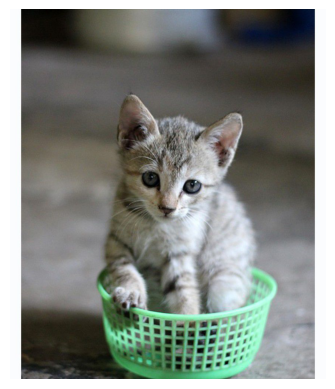

In [5]:
from PIL import Image # pip install Pillow

# Load an image
img = Image.open('res/cat.jpg')
plt.imshow(img)
plt.axis('off')

print(img.size)

In [6]:
transform = transforms.Compose([transforms.CenterCrop((512,512)),
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x[:3])]) # remove the alpha channel if present
img_tensor = transform(img)
img_tensor = img_tensor.to(device)

In [7]:
# Use HOOKS
conv_output = []

#append all the conv layers and their respective wights to the list
def append_conv(module, input, output):
    print("Output size {}".format(output.size()))
    conv_output.append(output.detach().cpu())

In [8]:
for k in layers_list:
    alexnet.features[k].register_forward_hook(append_conv)

In [9]:
conv_output = []
# pass the image through the net

out = alexnet(img_tensor.unsqueeze(0))

for c_out in conv_output:
    print(c_out.size())

Output size torch.Size([1, 64, 63, 63])
Output size torch.Size([1, 192, 31, 31])
Output size torch.Size([1, 384, 15, 15])
Output size torch.Size([1, 256, 15, 15])
Output size torch.Size([1, 256, 15, 15])
torch.Size([1, 64, 63, 63])
torch.Size([1, 192, 31, 31])
torch.Size([1, 384, 15, 15])
torch.Size([1, 256, 15, 15])
torch.Size([1, 256, 15, 15])


torch.Size([64, 63, 63])
torch.Size([64, 31, 31])
torch.Size([64, 15, 15])
torch.Size([64, 15, 15])
torch.Size([64, 15, 15])


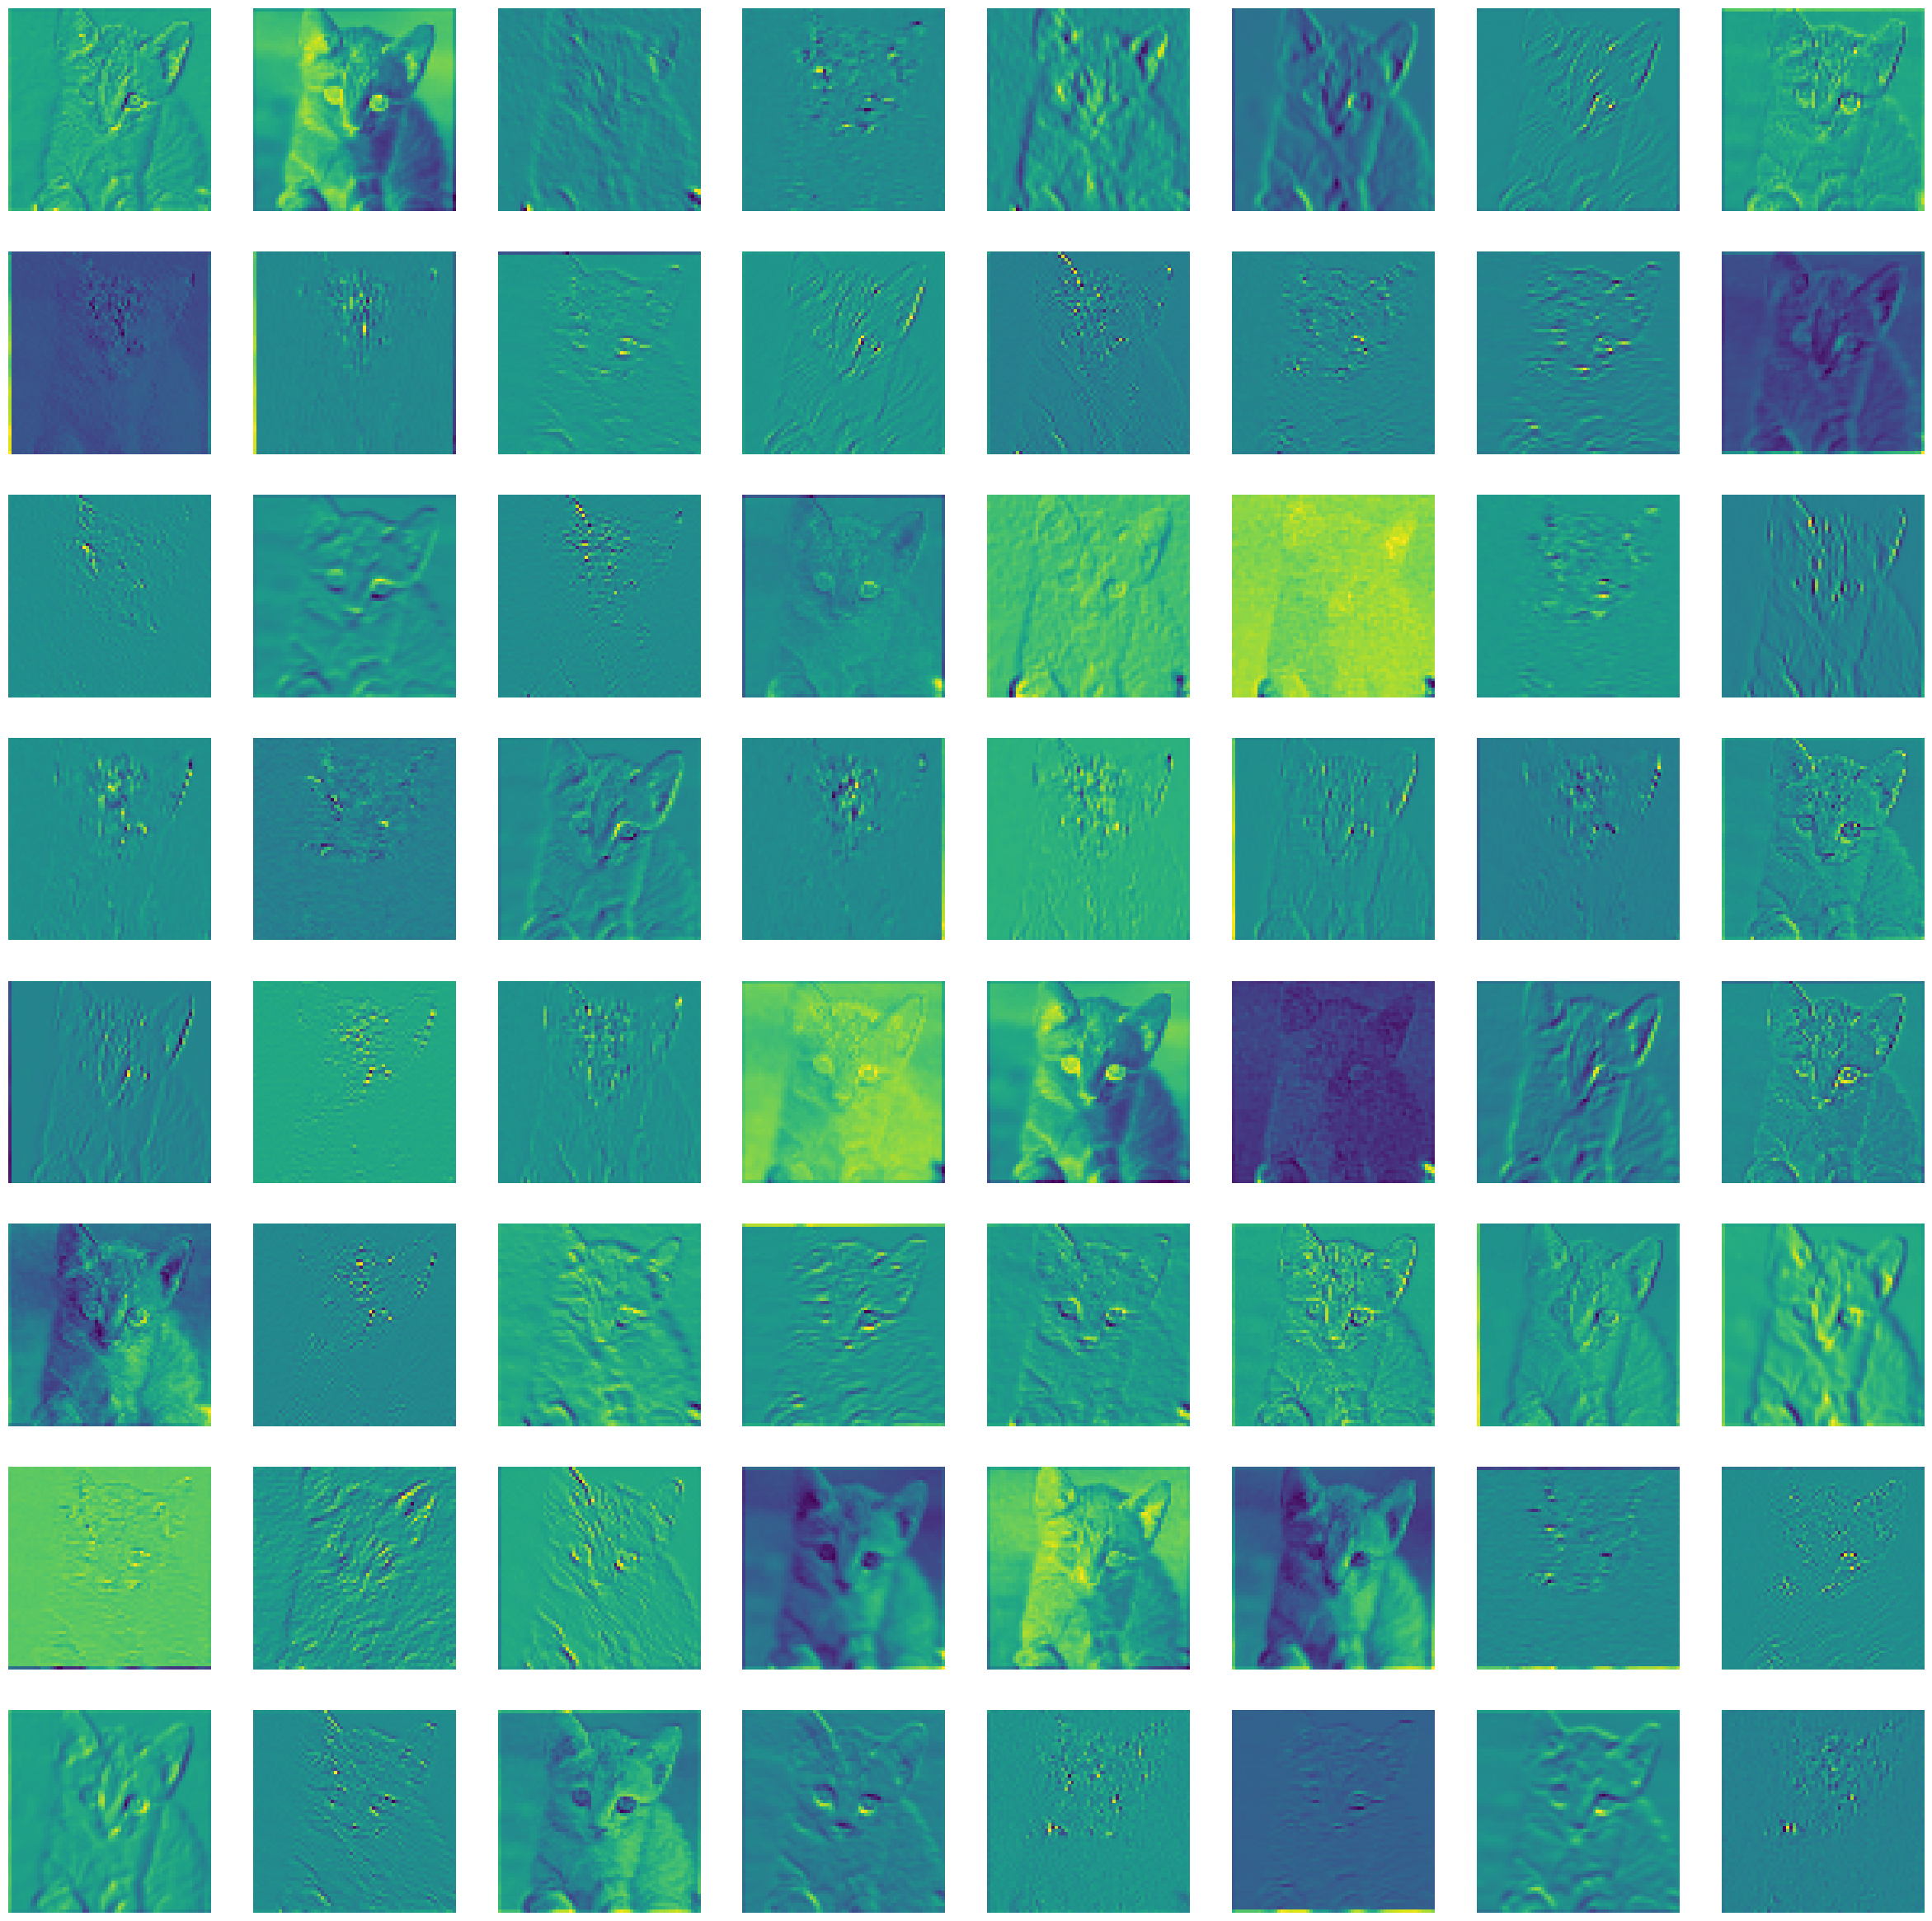

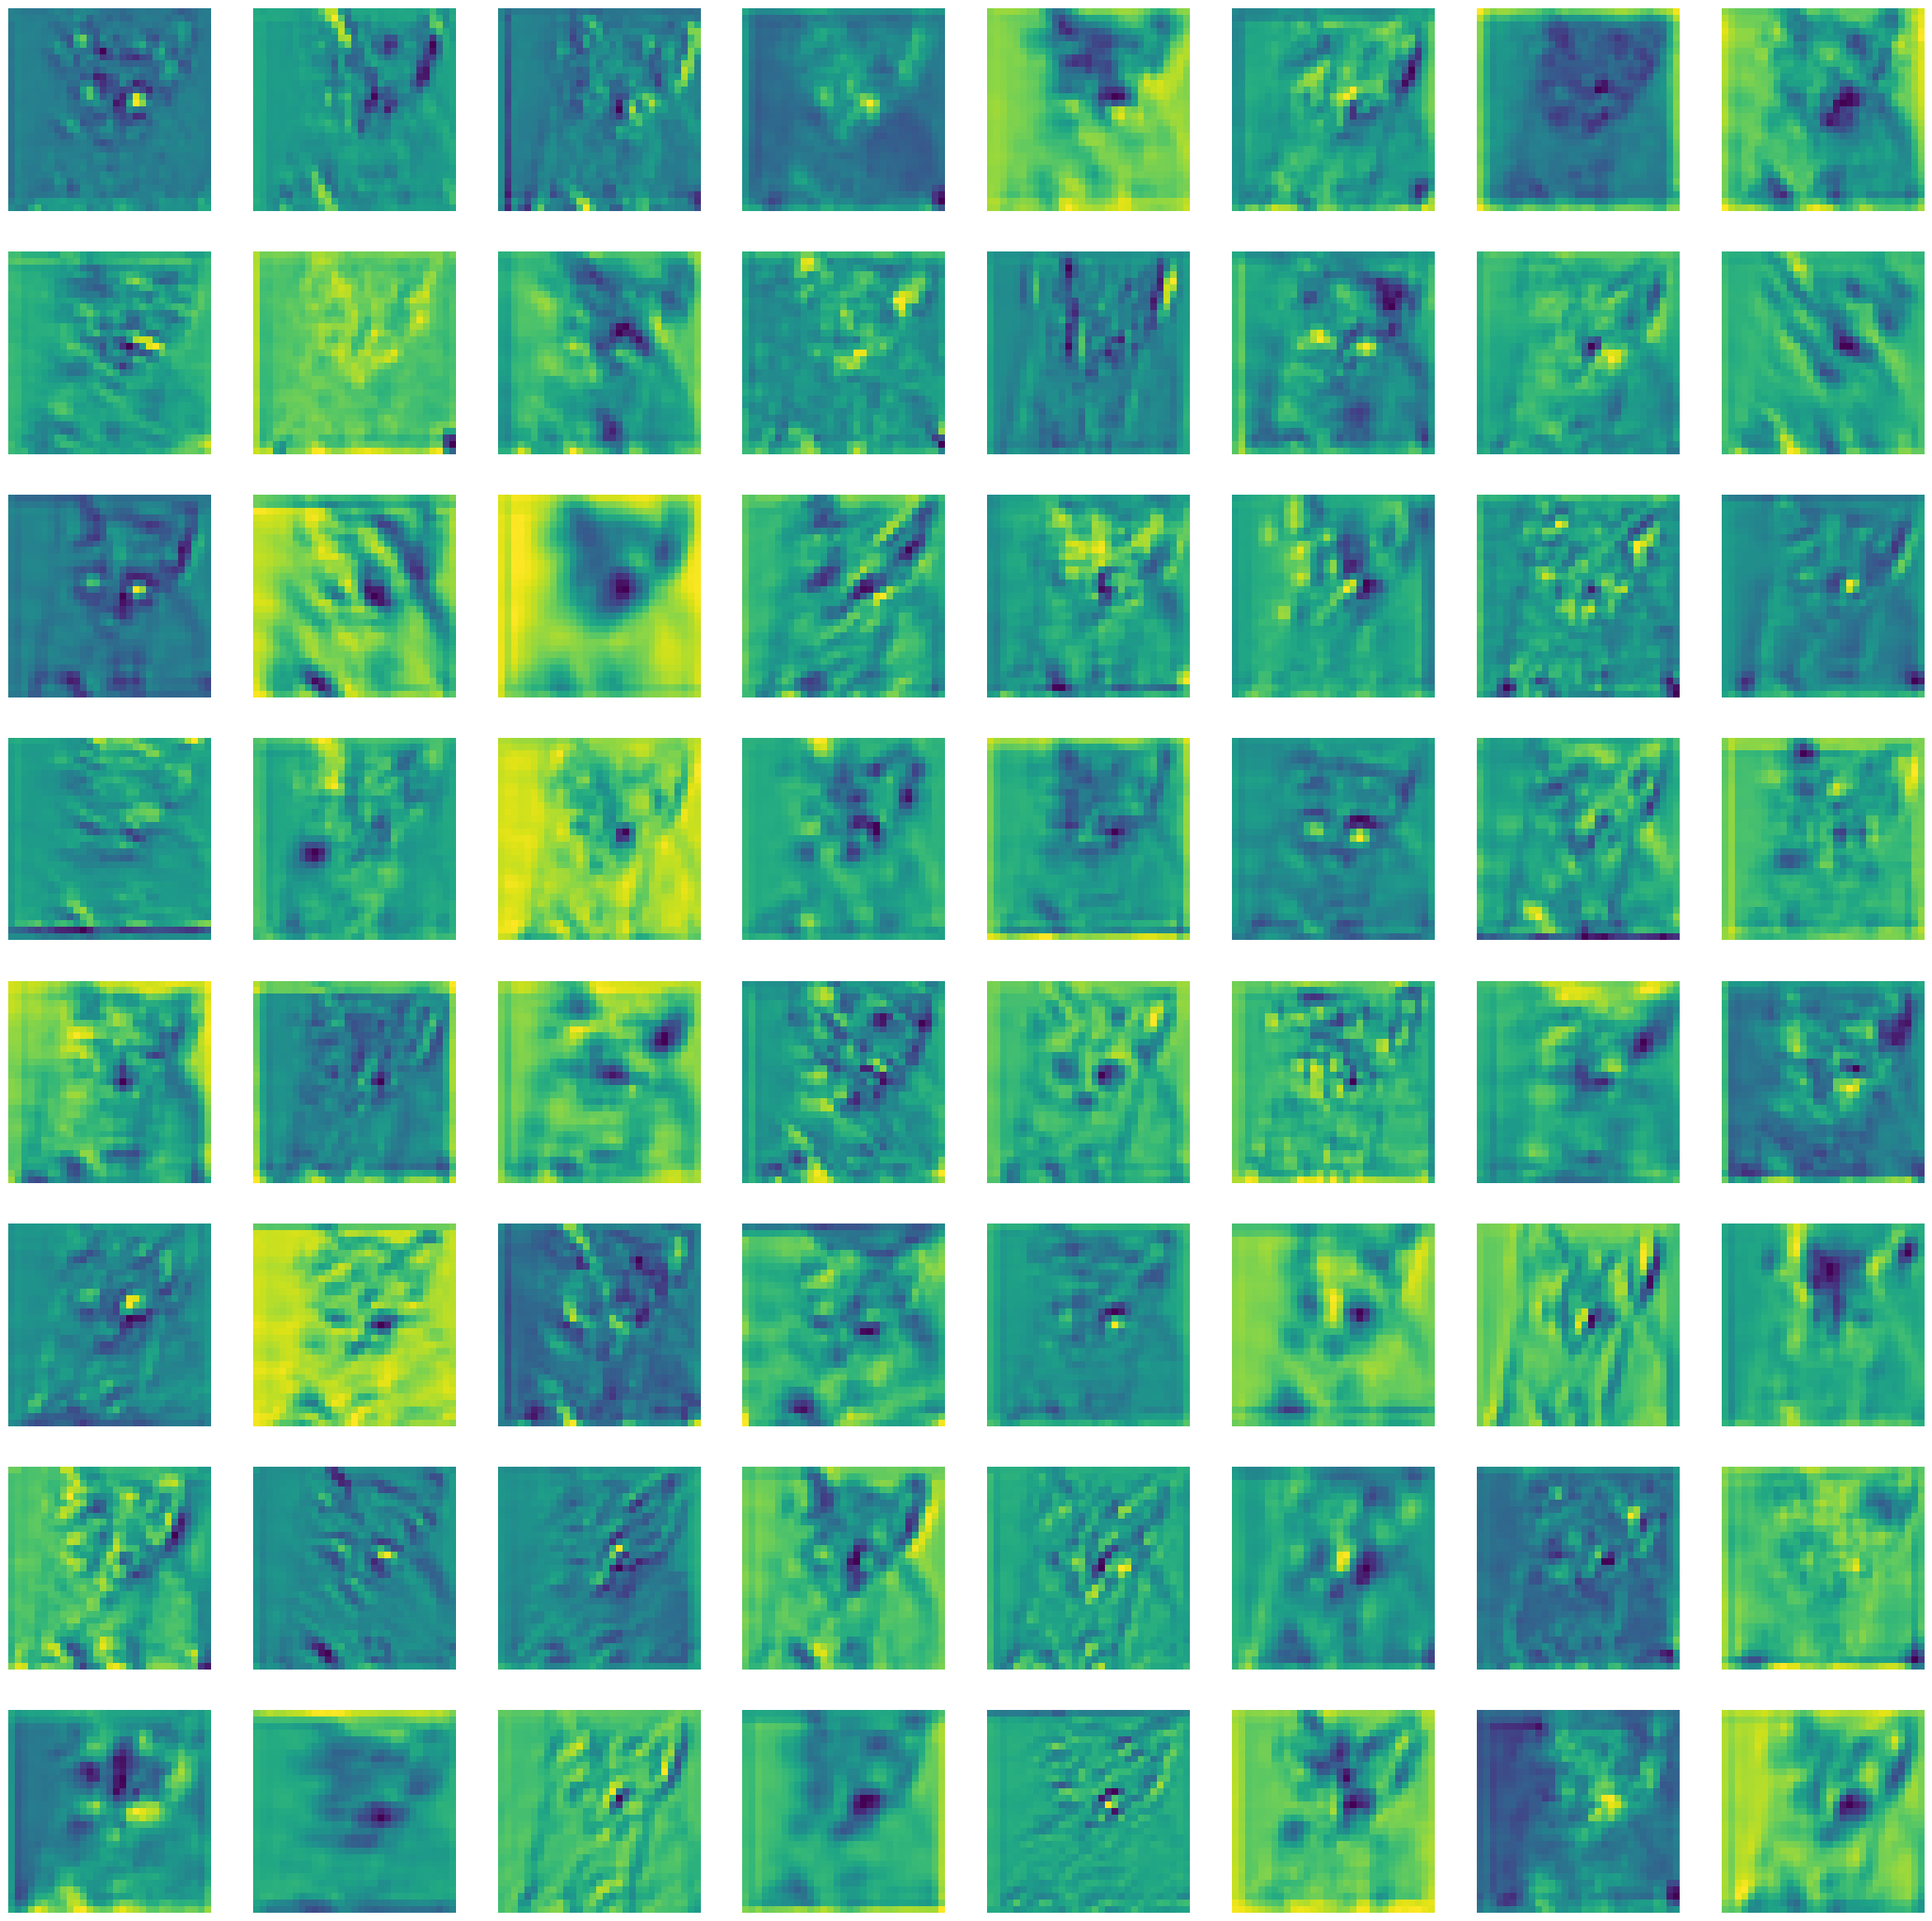

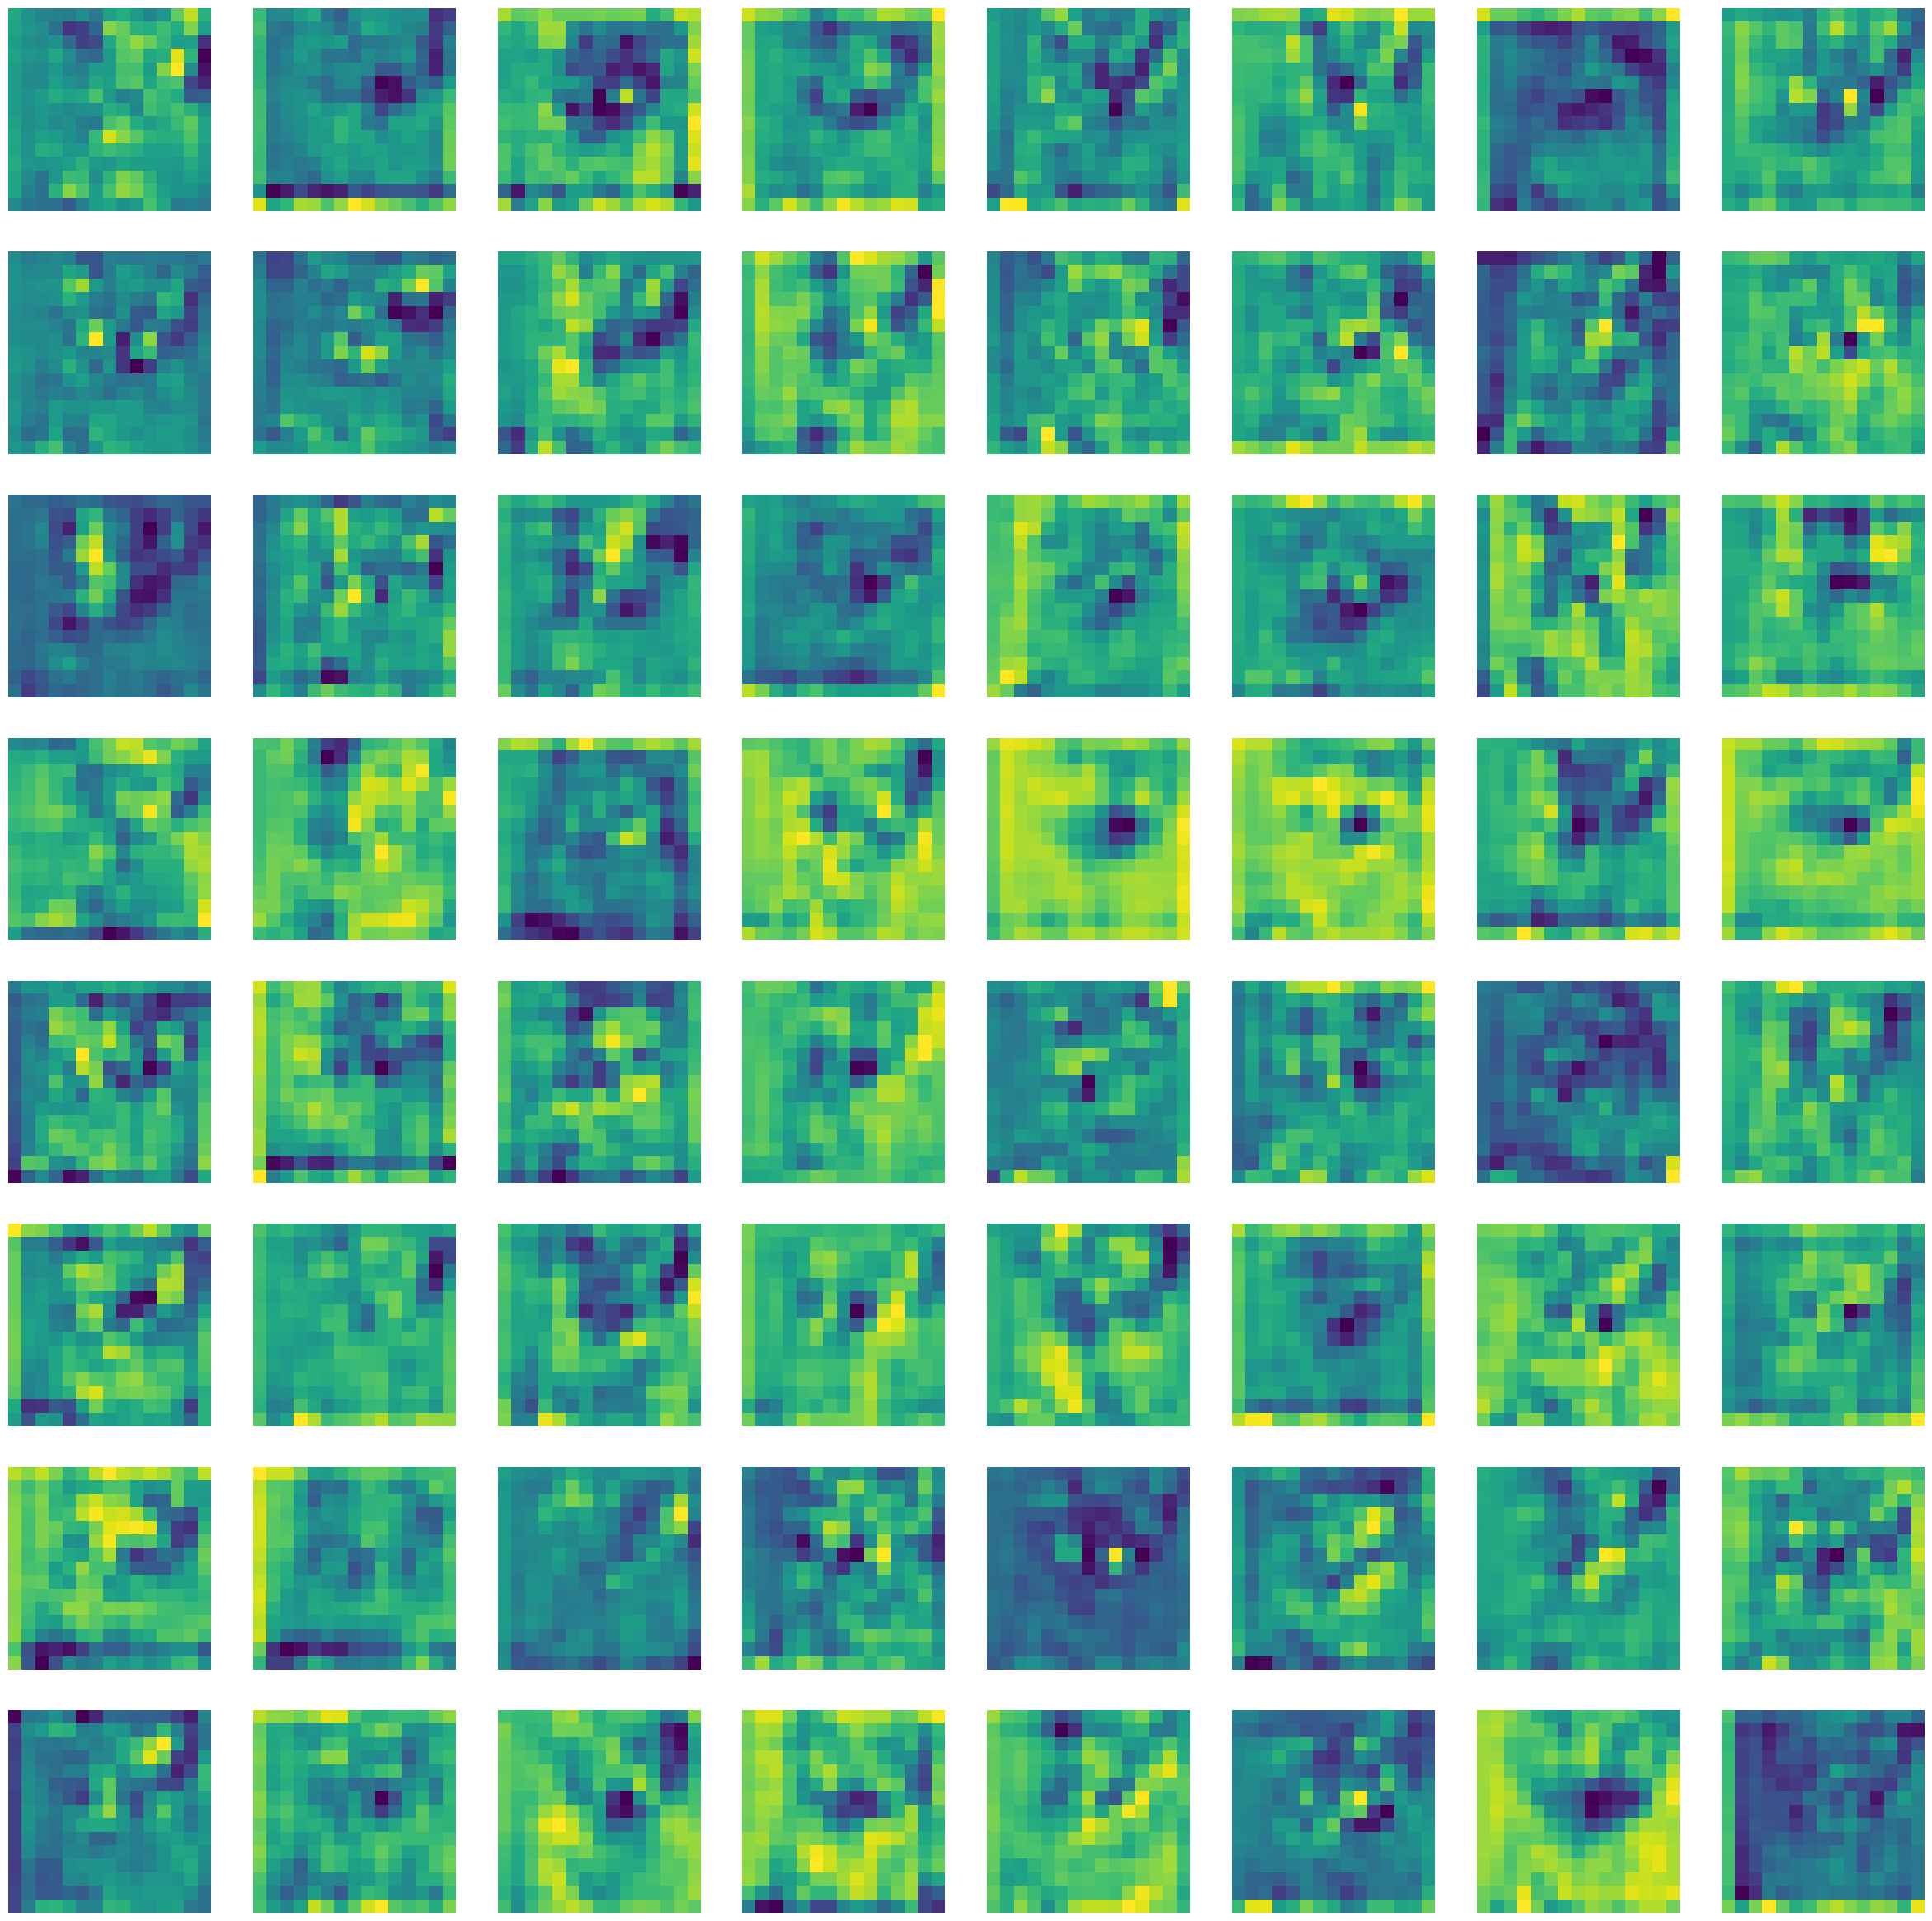

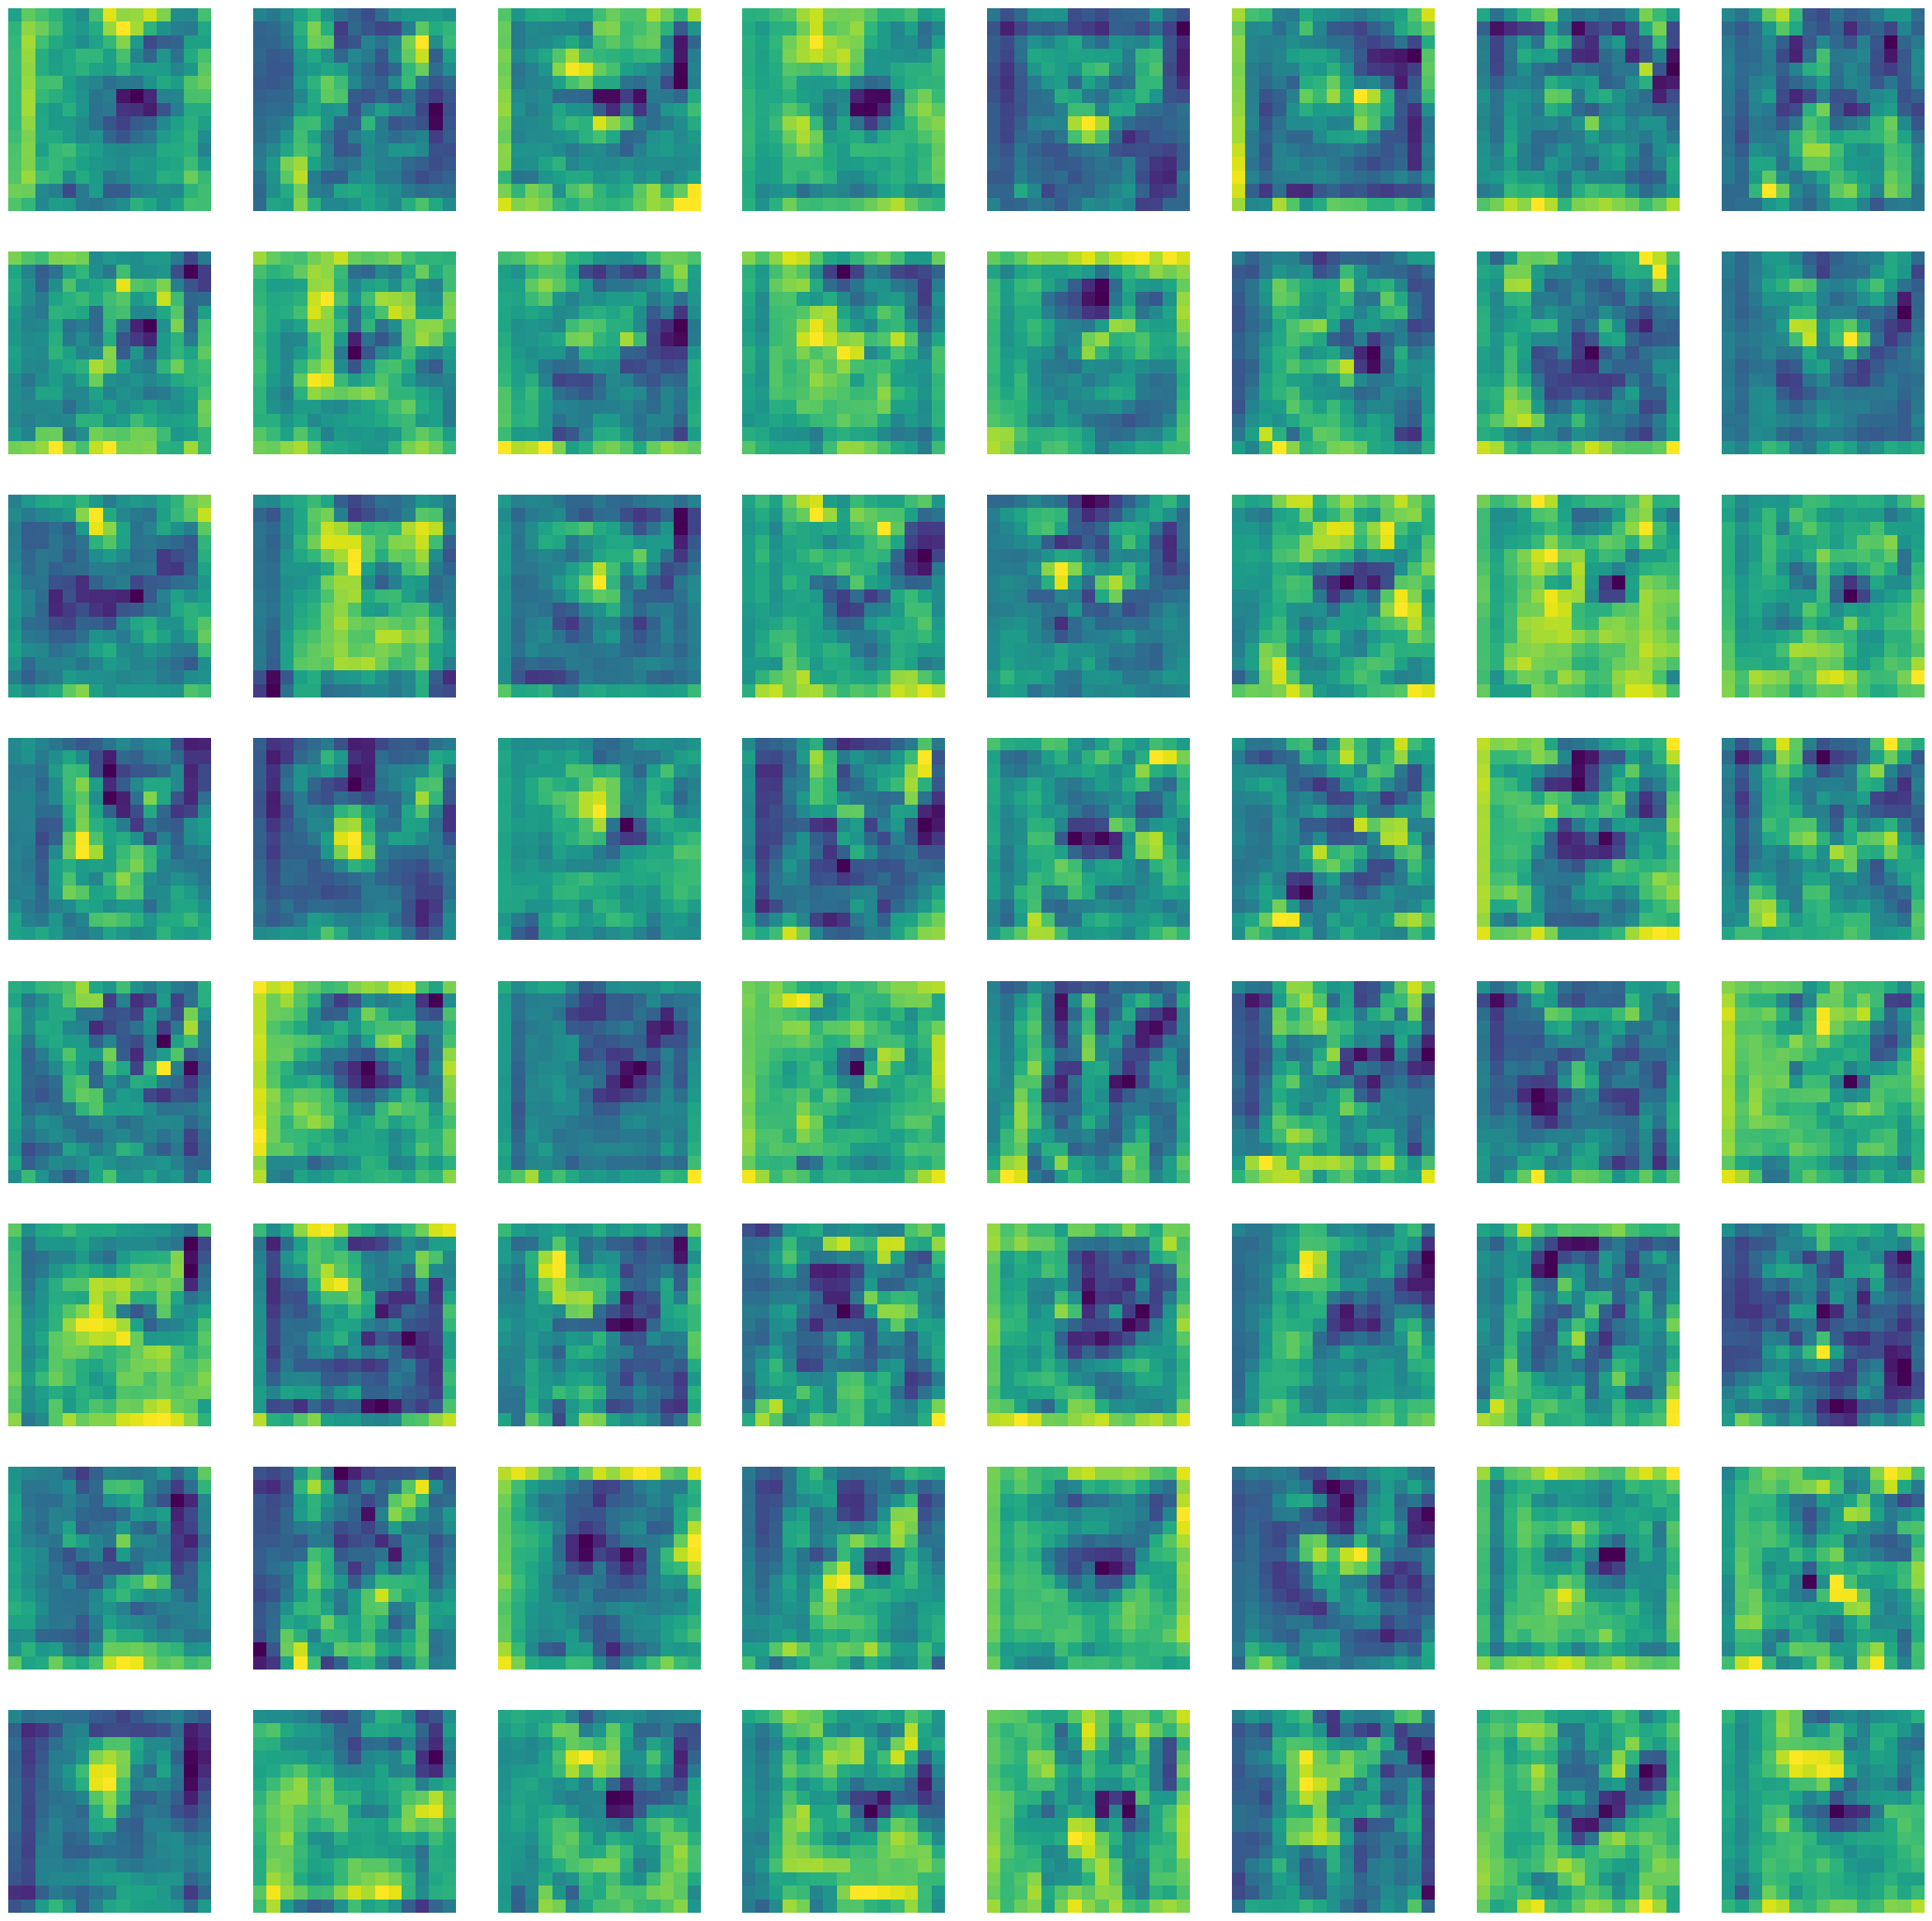

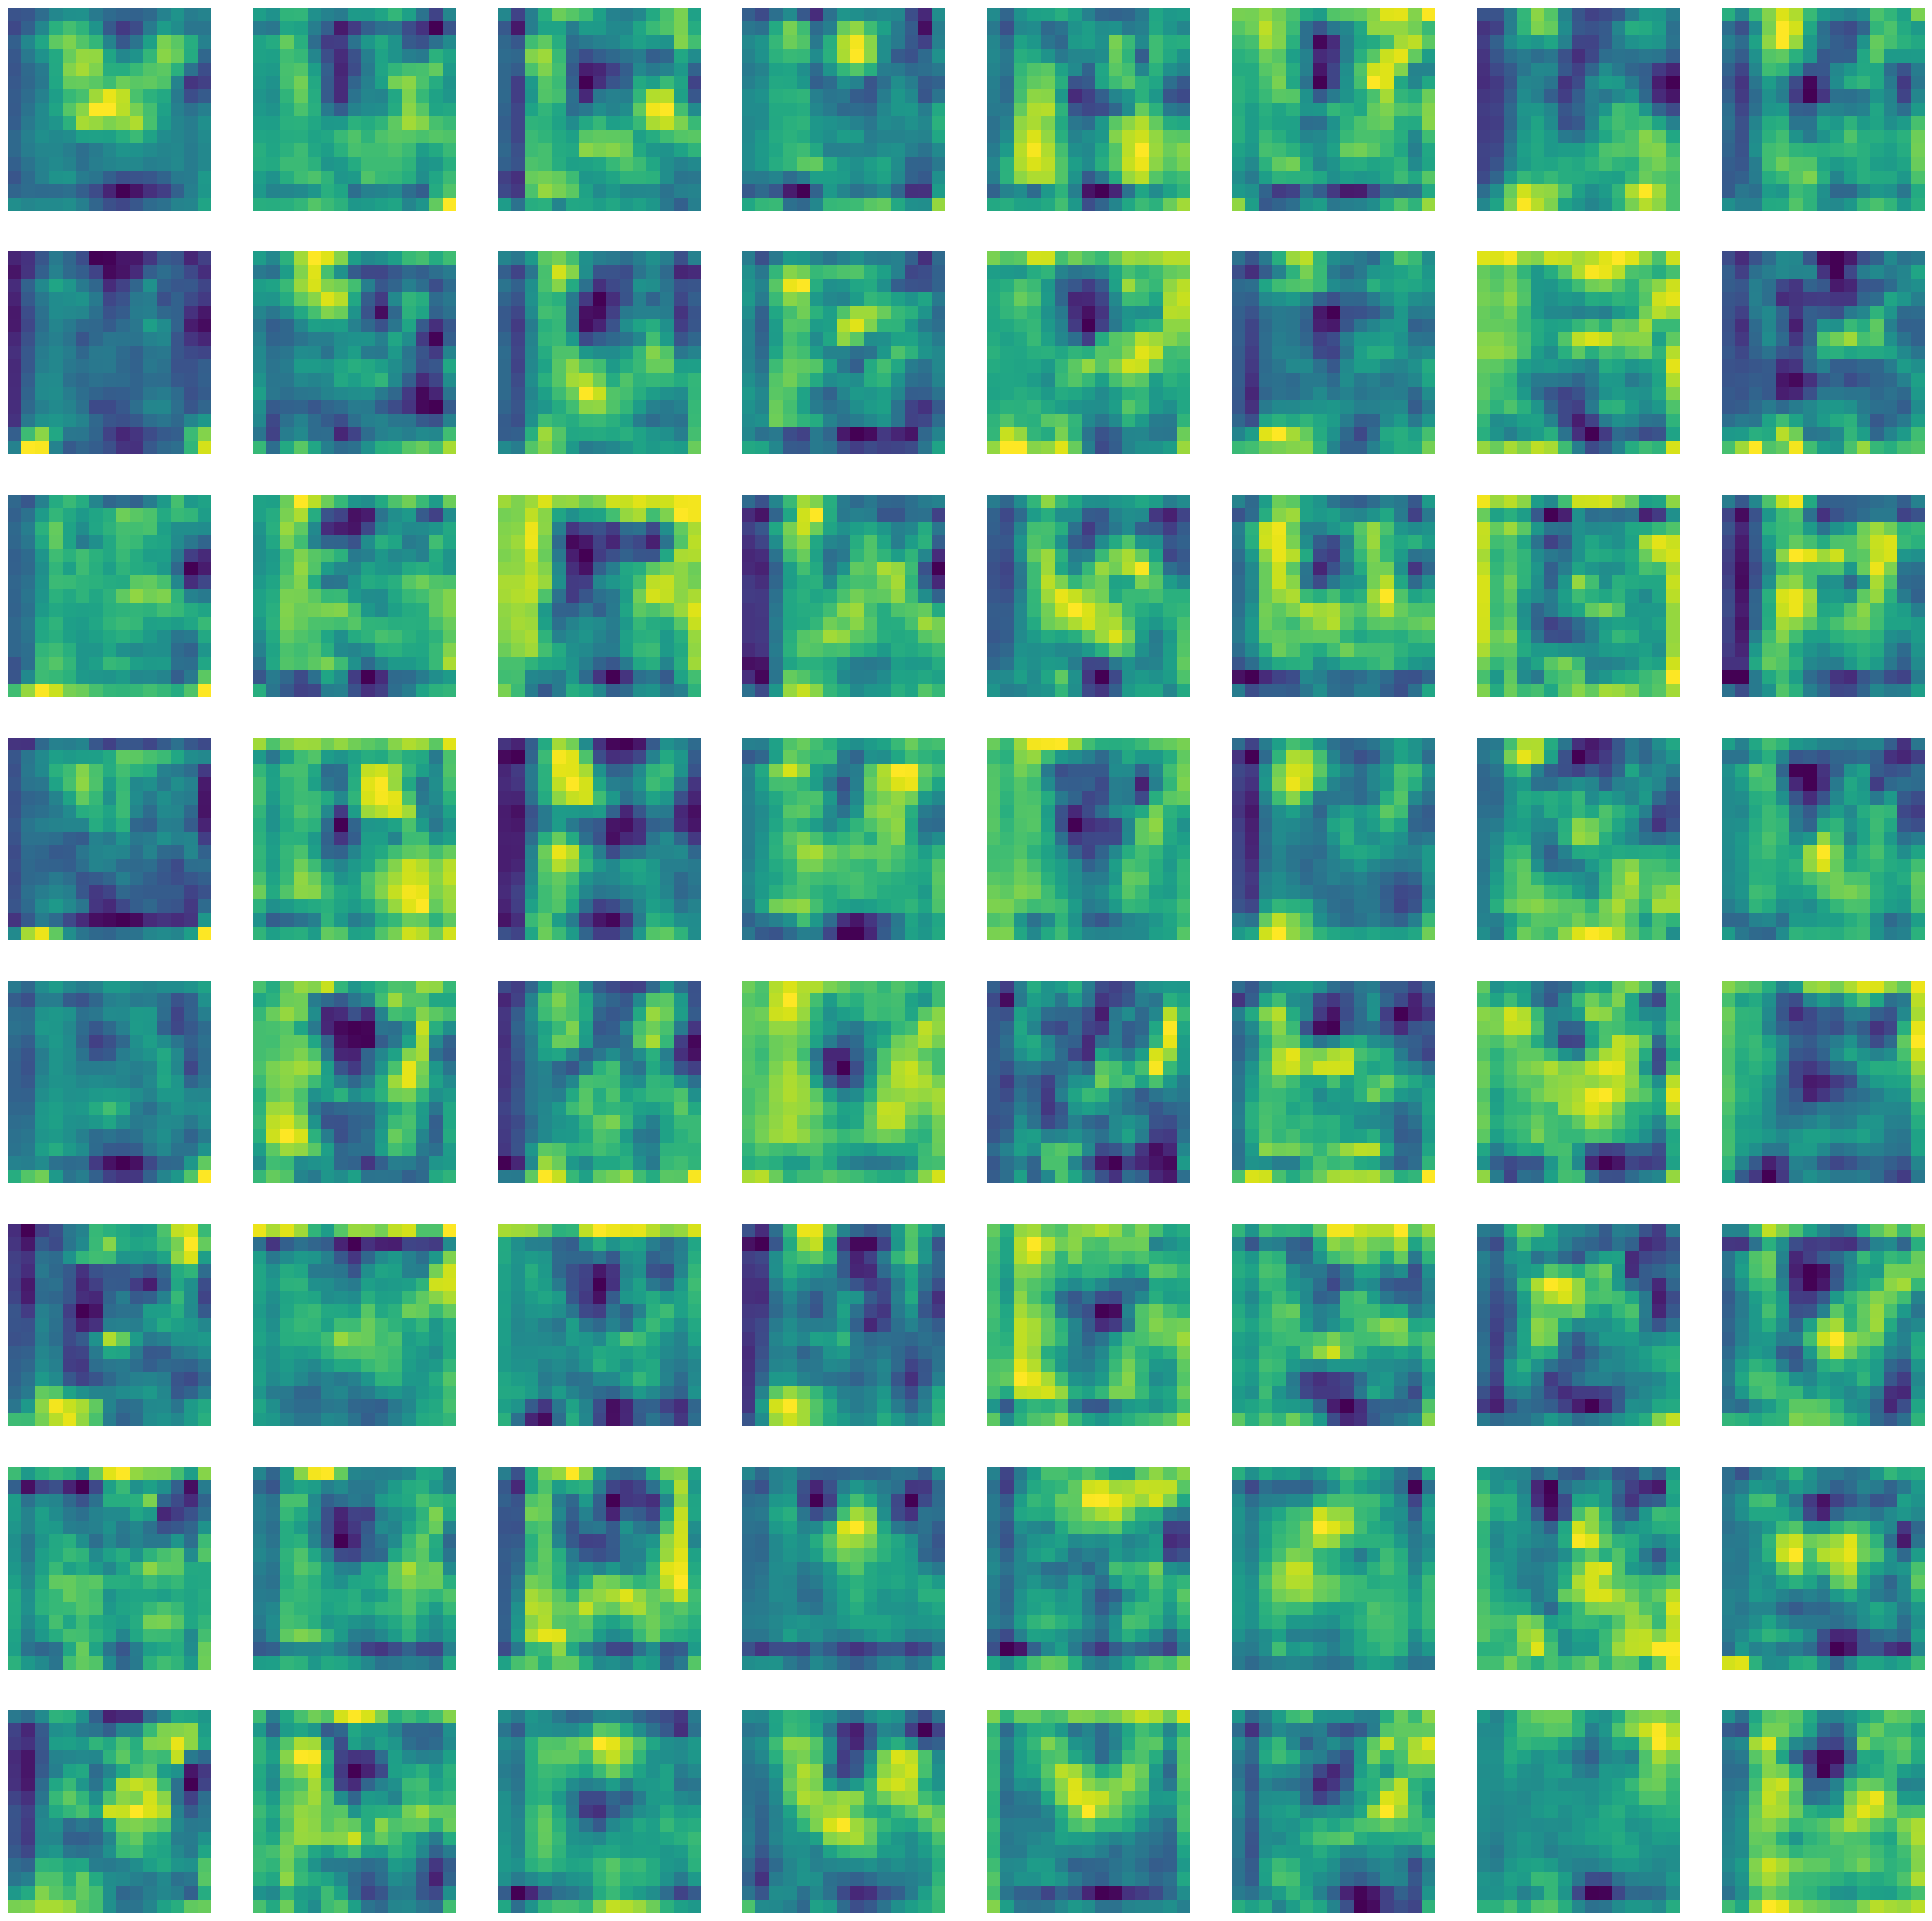

In [10]:
for num_layer in range(len(conv_output)):
    plt.figure(figsize=(30, 30))
    layer_viz = conv_output[num_layer][0, :64, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")